# SD Neighborhood Pulse: Story-Driven EDA

This notebook answers three questions:
1. Where is neighborhood service pressure rising right now?
2. What is driving that pressure (backlog, aging, repeat, resolution)?
3. How confident are we in these findings given data quality trends?

## Reader guide

- **frustration_index**: a composite signal of service pressure. Higher values indicate more unresolved or repeating demand pressure.
- **window_days**: rolling lookback window (30-day and 90-day).
- **component scores**: interpretable drivers of frustration index (backlog, aging, repeat, resolution lag).
- **Unknown rate**: share of records that cannot be assigned to a neighborhood dimension. Higher Unknown rates reduce confidence.

In [1]:
from pathlib import Path

import duckdb
import pandas as pd
import plotly.express as px

pd.set_option('display.max_columns', 50)

DB_PATH = Path('../data/db/city_health.duckdb')
assert DB_PATH.exists(), f'Missing DuckDB file: {DB_PATH.resolve()}'

In [2]:
# Parameters for easy reruns
PRIMARY_GRAIN = 'comm_plan_name'
WINDOWS = [30, 90]
PRIMARY_WINDOW = 30
TOP_N = 20
PEAK_N = 10
UNKNOWN_LABEL = 'Unknown'

In [3]:
con = duckdb.connect(str(DB_PATH), read_only=True)

frustration = con.execute('select * from fct_neighborhood_frustration_index').fetchdf()
daily_metrics = con.execute('select * from fct_neighborhood_daily_metrics').fetchdf()
hotspots = con.execute('select * from fct_request_hotspots').fetchdf()

print('frustration rows:', len(frustration))
print('daily_metrics rows:', len(daily_metrics))
print('hotspots rows:', len(hotspots))

frustration rows: 1522396
daily_metrics rows: 306271
hotspots rows: 4298


In [4]:
# Quick integrity checks
required_fr_cols = [
    'as_of_date',
    'grain_type',
    'grain_value',
    'window_days',
    'request_count',
    'frustration_index',
]
missing_fr = [c for c in required_fr_cols if c not in frustration.columns]
assert not missing_fr, f'Missing frustration columns: {missing_fr}'

frustration['as_of_date'] = pd.to_datetime(frustration['as_of_date'])
daily_metrics['metric_date'] = pd.to_datetime(daily_metrics['metric_date'])

print('frustration coverage:', frustration['as_of_date'].min().date(), 'to', frustration['as_of_date'].max().date())
display(
    frustration.groupby(['grain_type', 'window_days'], as_index=False)
    .agg(rows=('as_of_date', 'size'))
    .sort_values(['grain_type', 'window_days'])
)

frustration coverage: 2016-05-20 to 2026-02-13


,grain_type,window_days,rows
0,comm_plan_name,30,209863
1,comm_plan_name,90,209863
2,council_district,30,35570
3,council_district,90,35570
4,zipcode,30,515765
5,zipcode,90,515765


## 1) Citywide context first

Before ranking neighborhoods, check whether pressure is broadly rising or concentrated in specific places.

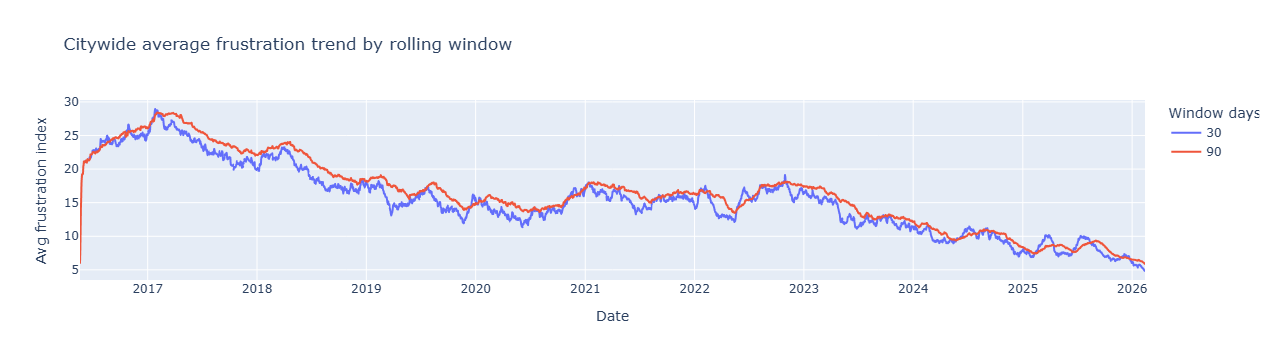

,as_of_date,window_days,avg_frustration_index,total_requests
7112,2026-02-13,30,4.827069,39356.0
7113,2026-02-13,90,5.897586,106676.0


In [5]:
citywide = frustration[
    (frustration['grain_type'] == PRIMARY_GRAIN)
    & (frustration['grain_value'] != UNKNOWN_LABEL)
    & (frustration['window_days'].isin(WINDOWS))
].copy()

if citywide.empty:
    print('No citywide rows found for selected grain/window settings.')
else:
    citywide_summary = (
        citywide.groupby(['as_of_date', 'window_days'], as_index=False)
        .agg(
            avg_frustration_index=('frustration_index', 'mean'),
            total_requests=('request_count', 'sum'),
        )
        .sort_values(['window_days', 'as_of_date'])
    )

    fig_city = px.line(
        citywide_summary,
        x='as_of_date',
        y='avg_frustration_index',
        color='window_days',
        title='Citywide average frustration trend by rolling window',
        labels={'as_of_date': 'Date', 'avg_frustration_index': 'Avg frustration index', 'window_days': 'Window days'},
    )
    fig_city.show()

    latest_date = citywide_summary['as_of_date'].max()
    display(citywide_summary[citywide_summary['as_of_date'] == latest_date])

## 2) Who is under the most pressure right now?

Rank neighborhoods using the latest 30-day snapshot.

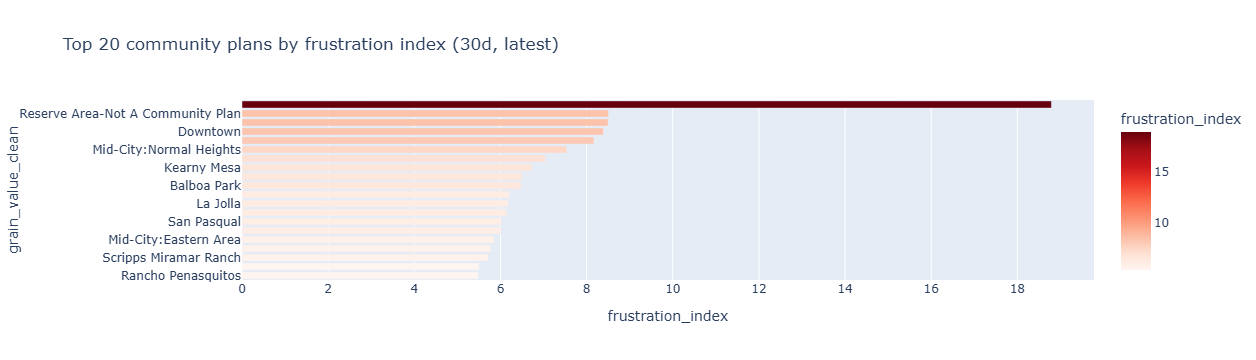

,community_plan,frustration_index,request_count,open_request_count,aging_open_request_count
0,Ncfua Subarea Ii,18.79,8.0,0.0,0.0
1,Reserve Area-Not A Community Plan,8.51,40.0,0.0,0.0
2,Sabre Springs,8.50,83.0,0.0,0.0
3,Downtown,8.39,3022.0,0.0,0.0
4,Carmel Mountain Ranch,8.17,158.0,0.0,0.0
5,Mid-City:Normal Heights,7.54,707.0,0.0,0.0
6,Mission Bay Park,7.04,359.0,0.0,0.0
7,Kearny Mesa,6.73,398.0,0.0,0.0
8,Rancho Bernardo,6.50,351.0,0.0,0.0
9,Balboa Park,6.48,337.0,0.0,0.0


Unknown rows in latest cut: 1 of 59


In [7]:
latest = frustration['as_of_date'].max()
focus = frustration[
    (frustration['as_of_date'] == latest)
    & (frustration['window_days'] == PRIMARY_WINDOW)
    & (frustration['grain_type'] == PRIMARY_GRAIN)
].copy()

focus['is_unknown'] = focus['grain_value'] == UNKNOWN_LABEL
focus_known = focus[~focus['is_unknown']].copy()
focus_known['grain_value_clean'] = focus_known['grain_value'].astype(str).str.strip().str.title()

top_focus = focus_known.sort_values('frustration_index', ascending=False).head(TOP_N)

if top_focus.empty:
    print('No latest neighborhood rows available for ranking.')
else:
    fig_rank = px.bar(
        top_focus.sort_values('frustration_index', ascending=True),
        x='frustration_index',
        y='grain_value_clean',
        orientation='h',
        color='frustration_index',
        color_continuous_scale='Reds',
        title=f'Top {TOP_N} community plans by frustration index ({PRIMARY_WINDOW}d, latest)',
    )
    fig_rank.show()

    summary_table = top_focus[
        ['grain_value_clean', 'frustration_index', 'request_count', 'open_request_count', 'aging_open_request_count']
    ].rename(columns={'grain_value_clean': 'community_plan'})
    display(summary_table.reset_index(drop=True))

print('Unknown rows in latest cut:', int(focus['is_unknown'].sum()), 'of', len(focus))

## 3) Why are these neighborhoods elevated?

Decompose pressure into component drivers for the top-ranked neighborhoods.

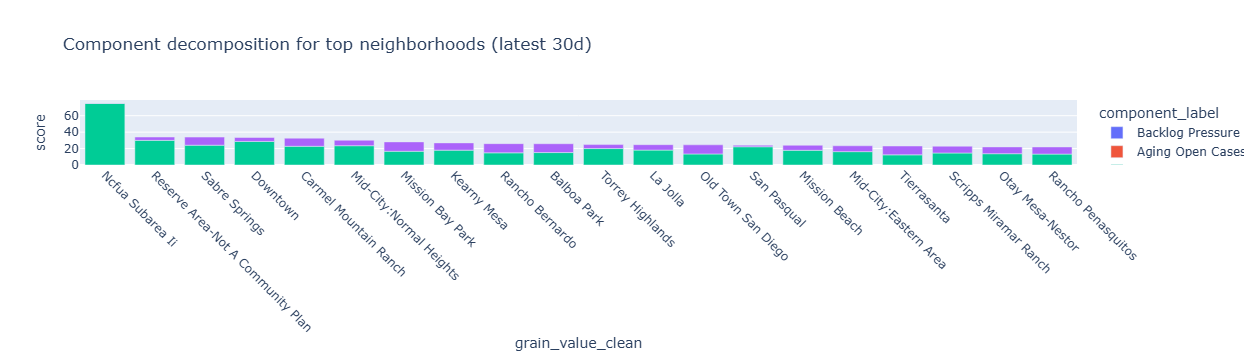

,grain_value_clean,dominant_driver,backlog_component,aging_component,repeat_component,resolution_component
271298,Ncfua Subarea Ii,Repeat Requests,0.0,0.0,75.00,0.17
489894,Reserve Area-Not A Community Plan,Repeat Requests,0.0,0.0,30.00,4.06
404095,Sabre Springs,Repeat Requests,0.0,0.0,24.10,9.89
722608,Downtown,Repeat Requests,0.0,0.0,28.72,4.83
493990,Carmel Mountain Ranch,Repeat Requests,0.0,0.0,22.78,9.89
98409,Mid-City:Normal Heights,Repeat Requests,0.0,0.0,23.48,6.67
28455,Mission Bay Park,Repeat Requests,0.0,0.0,16.71,11.44
449257,Kearny Mesa,Repeat Requests,0.0,0.0,18.09,8.83
305254,Rancho Bernardo,Repeat Requests,0.0,0.0,14.81,11.17
484180,Balboa Park,Repeat Requests,0.0,0.0,15.13,10.78


In [9]:
component_cols = ['backlog_component', 'aging_component', 'repeat_component', 'resolution_component']
component_labels = {
    'backlog_component': 'Backlog Pressure',
    'aging_component': 'Aging Open Cases',
    'repeat_component': 'Repeat Requests',
    'resolution_component': 'Resolution Lag',
}

if top_focus.empty:
    print('No top neighborhoods available for decomposition.')
else:
    decomp = top_focus[['grain_value_clean'] + component_cols].copy()
    decomp_long = decomp.melt(
        id_vars='grain_value_clean',
        value_vars=component_cols,
        var_name='component',
        value_name='score',
    )
    decomp_long['component_label'] = decomp_long['component'].map(component_labels)

    fig_decomp = px.bar(
        decomp_long,
        x='grain_value_clean',
        y='score',
        color='component_label',
        title='Component decomposition for top neighborhoods (latest 30d)',
    )
    fig_decomp.update_xaxes(tickangle=45)
    fig_decomp.show()

    dominant = top_focus[['grain_value_clean'] + component_cols].copy()
    dominant['dominant_driver'] = dominant[component_cols].idxmax(axis=1).map(component_labels)
    display(dominant[['grain_value_clean', 'dominant_driver'] + component_cols])

## 4) Peak-day episodes

For the highest-pressure neighborhood, identify top peak-volume days and likely driver context.

Top 10 peak-volume days for Ncfua Subarea Ii


,as_of_date,request_count,frustration_index,driver_component,backlog_component,aging_component,repeat_component,resolution_component
313254,2023-03-29,27.0,26.17,Repeat Requests,0.0,0.0,55.56,49.11
313255,2023-03-30,27.0,24.74,Repeat Requests,0.0,0.0,51.85,47.11
313256,2023-03-31,26.0,23.14,Repeat Requests,0.0,0.0,50.00,42.56
313261,2023-04-05,26.0,23.34,Repeat Requests,0.0,0.0,57.69,35.67
313266,2023-04-10,26.0,23.33,Repeat Requests,0.0,0.0,57.69,35.61
313267,2023-04-11,26.0,23.33,Repeat Requests,0.0,0.0,57.69,35.61
313263,2023-04-07,26.0,23.34,Repeat Requests,0.0,0.0,57.69,35.67
313262,2023-04-06,26.0,23.34,Repeat Requests,0.0,0.0,57.69,35.67
313253,2023-03-28,26.0,25.31,Repeat Requests,0.0,0.0,57.69,43.56
313268,2023-04-12,25.0,21.15,Repeat Requests,0.0,0.0,52.00,32.61


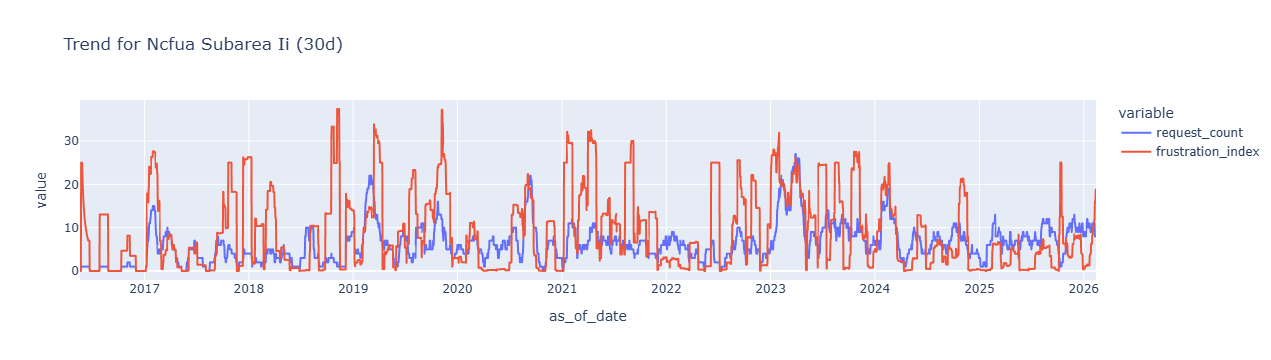

In [10]:
target_value = top_focus.iloc[0]['grain_value'] if not top_focus.empty else None

if target_value is None:
    print('No target neighborhood available for peak analysis.')
else:
    trend = frustration[
        (frustration['grain_type'] == PRIMARY_GRAIN)
        & (frustration['grain_value'] == target_value)
        & (frustration['window_days'] == PRIMARY_WINDOW)
    ].sort_values('as_of_date').copy()

    peak_days = trend.sort_values('request_count', ascending=False).head(PEAK_N).copy()
    peak_days['driver_component'] = peak_days[component_cols].idxmax(axis=1).map(component_labels)

    print(f'Top {PEAK_N} peak-volume days for {str(target_value).title()}')
    display(peak_days[['as_of_date', 'request_count', 'frustration_index', 'driver_component'] + component_cols])

    fig_target = px.line(
        trend,
        x='as_of_date',
        y=['request_count', 'frustration_index'],
        title=f'Trend for {str(target_value).title()} ({PRIMARY_WINDOW}d)',
    )
    fig_target.show()

## 5) Confidence lens: Unknown-rate trends

Track Unknown share over time to evaluate how much geospatial assignment uncertainty may affect interpretation.

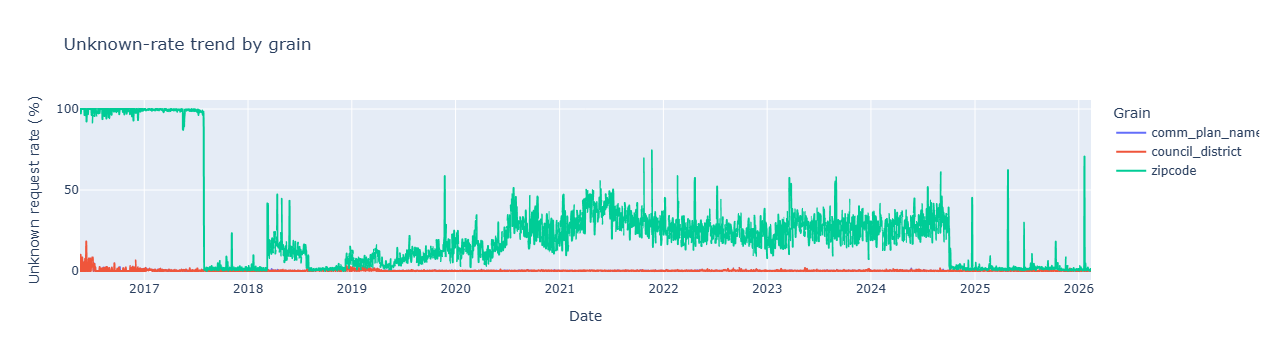

,grain_type,metric_date,unknown_request_rate_pct,confidence_band
0,council_district,2026-02-13,0.103306,High confidence
1,comm_plan_name,2026-02-13,0.103306,High confidence
2,zipcode,2026-02-13,0.309917,High confidence


In [11]:
quality = daily_metrics[daily_metrics['grain_type'].isin(['comm_plan_name', 'council_district', 'zipcode'])].copy()
quality['is_unknown'] = quality['grain_value'] == UNKNOWN_LABEL

unknown = (
    quality.groupby(['grain_type', 'metric_date'], as_index=False)
    .agg(
        request_count=('request_count', 'sum'),
        unknown_request_count=('request_count', lambda s: s[quality.loc[s.index, 'is_unknown']].sum()),
    )
)
unknown['unknown_request_rate_pct'] = (
    unknown['unknown_request_count'] / unknown['request_count'].where(unknown['request_count'] != 0, 1)
) * 100

fig_unknown = px.line(
    unknown,
    x='metric_date',
    y='unknown_request_rate_pct',
    color='grain_type',
    title='Unknown-rate trend by grain',
    labels={'unknown_request_rate_pct': 'Unknown request rate (%)', 'metric_date': 'Date', 'grain_type': 'Grain'},
)
fig_unknown.show()

latest_unknown = unknown.sort_values('metric_date').groupby('grain_type').tail(1).copy()
latest_unknown['confidence_band'] = pd.cut(
    latest_unknown['unknown_request_rate_pct'],
    bins=[-0.01, 5, 15, 100],
    labels=['High confidence', 'Medium confidence', 'Low confidence'],
)
display(latest_unknown[['grain_type', 'metric_date', 'unknown_request_rate_pct', 'confidence_band']].reset_index(drop=True))

## 6) Robustness check: component stability

Sanity-check whether component signals are informative and stable over time for the primary grain.

In [12]:
trend_cp = frustration[
    (frustration['window_days'] == PRIMARY_WINDOW)
    & (frustration['grain_type'] == PRIMARY_GRAIN)
    & (frustration['grain_value'] != UNKNOWN_LABEL)
].copy()

if trend_cp.empty:
    print('No rows available for robustness checks.')
else:
    for col in component_cols:
        trend_cp[col] = pd.to_numeric(trend_cp[col], errors='coerce')

    latest_cut = trend_cp[trend_cp['as_of_date'] == trend_cp['as_of_date'].max()].copy()
    variance_df = (
        latest_cut[component_cols].agg(['mean', 'std', 'min', 'max']).T.reset_index()
        .rename(columns={'index': 'component'})
        .sort_values('std', ascending=False)
    )

    daily_change = (
        trend_cp.sort_values(['grain_value', 'as_of_date'])
        .groupby('grain_value')[component_cols]
        .diff()
        .abs()
    )
    stability = daily_change.median().rename('median_abs_daily_change').reset_index().rename(columns={'index': 'component'})

    display(variance_df)
    display(stability.sort_values('median_abs_daily_change', ascending=False))
    display(trend_cp[component_cols].corr().round(2))

,component,mean,std,min,max
2,repeat_component,13.338448,10.600800,0.0,75.00
3,resolution_component,5.968276,3.069622,0.0,11.44
1,aging_component,0.000000,0.000000,0.0,0.00
0,backlog_component,0.000000,0.000000,0.0,0.00


,component,median_abs_daily_change
2,repeat_component,0.22
3,resolution_component,0.11
1,aging_component,0.00
0,backlog_component,0.00


,backlog_component,aging_component,repeat_component,resolution_component
backlog_component,NaN,NaN,NaN,NaN
aging_component,NaN,NaN,NaN,NaN
repeat_component,NaN,NaN,1.00,0.12
resolution_component,NaN,NaN,0.12,1.00


## 7) Operational takeaways

Use this section to summarize current implications after running the notebook:

- Which neighborhoods should be monitored weekly?
- Which driver is most common among top-ranked neighborhoods?
- Are Unknown rates acceptable for decision-making at each grain?
- What tactical intervention is suggested by dominant drivers (repeat vs resolution lag)?
- What should be rechecked on the next refresh?